### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x

In [2]:
from help_funcs import * 
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.106:43862 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.106:43862,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
GLORYS_dir = r"/vortexfs1/share/cdx/hseo/Data/MERCATOR/NEP_daily" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [6]:
def _preprocess(ds):
    return ds[["thetao", "zos"]].sel(latitude = slice(-2, 60), 
                                     longitude = slice(-150, -75), depth = slice(0, 50))

In [7]:
ds = xr.open_mfdataset(
        results,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        preprocess=_preprocess,
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":2},
        engine="scipy")

In [8]:
#save the dataset before processing 
ds.to_netcdf(GLORYS_data_dir("GLORYS_NE_PAC.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/client.py:3106: UserWarning: Sending large graph of size 43.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [9]:
#do not change chunks, this is the fastest wat
ds = xr.open_mfdataset(GLORYS_data_dir("GLORYS_NE_PAC.nc"), 
                            data_vars="minimal",
                            coords="minimal",
                            compat="override",
                            preprocess=_preprocess,
                            parallel=True,
                            chunks={"longitude":-1, "latitude":-1, "time":720, "depth":1}, 
                            engine="netcdf4")

In [36]:
ds = ds.convert_calendar('noleap') #remove leap years from operations
ds_climatology = ds.groupby("time.dayofyear").mean(dim = "time")

In [ ]:
ds_climatology.to_netcdf(GLORYS_data_dir("GLORYS_SFC_Climatology.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/client.py:3106: UserWarning: Sending large graph of size 15.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [12]:
ds_climatology = xr.open_dataset(GLORYS_data_dir("GLORYS_SFC_Climatology.nc")).compute()

In [13]:
ds_climatology.latitude

<xarray.DataArray 'latitude' (latitude: 745)>
array([-2.      , -1.916667, -1.833333, ..., 59.833332, 59.916668, 60.      ],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -2.0 -1.917 -1.833 -1.75 ... 59.83 59.92 60.0
Attributes:
    valid_min:            -20.0
    valid_max:            70.0
    step:                 0.08333588
    units:                degrees_north
    unit_long:            Degrees North
    long_name:            Latitude
    standard_name:        latitude
    axis:                 Y
    _ChunkSizes:          2041
    _CoordinateAxisType:  Lat

In [25]:
from scipy.signal import sosfiltfilt, butter
def smooth_daily_climatology_fast(daily_climatology, axis = "dayofyear"):
    smooth_climatology = 0.0 * daily_climatology.compute()
    sos = butter(4, 1/20, btype='low', output='sos')
    nlon = len(daily_climatology.longitude)

    for key in daily_climatology.keys():
        axis_num = daily_climatology[key].get_axis_num(axis)
        for ilon in np.arange(0, nlon):
            data = daily_climatology[key].isel(longitude = ilon).values.T
            wherenan = np.isnan(data)
            data[wherenan] = 0.0

            extend_data = np.concatenate([data[..., -60:], data, data[..., :60]], axis = -1)
            #apply filter to obtain a smooth daily climatology
            ysmooth = sosfiltfilt(sos, extend_data, axis = -1, 
                                  padtype = None, padlen = 0)[..., 60:-60]
            ysmooth[wherenan] = np.nan

            smooth_climatology[key].values[..., ilon] = ysmooth.T

    return smooth_climatology

In [26]:
smooth_climatology = smooth_daily_climatology_fast(ds_climatology)

In [27]:
smooth_climatology.to_netcdf(GLORYS_data_dir("GLORYS_SFC_SmoothClimatology.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

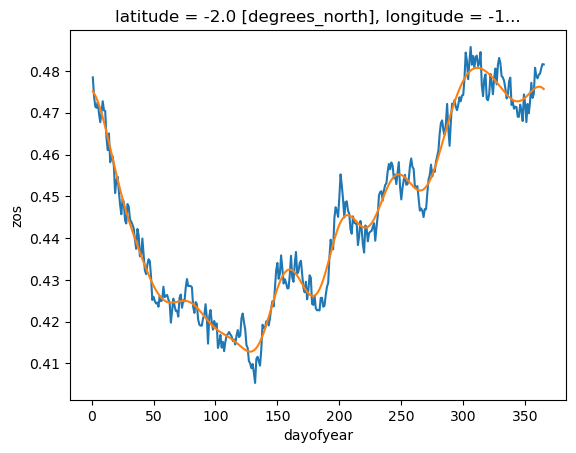

In [28]:
ds_climatology.zos.isel(longitude = 0, latitude = 0).plot()
smooth_climatology.zos.isel(longitude = 0, latitude = 0,).plot()

In [35]:
ds_climatology.thetao

<xarray.DataArray 'thetao' (dayofyear: 365, depth: 18, latitude: 745,
                            longitude: 901)>
array([[[[26.844645, 26.850555, 26.854506, ...,  0.      ,  0.      ,
           0.      ],
         [26.804073, 26.808153, 26.81129 , ...,  0.      ,  0.      ,
           0.      ],
         [26.759626, 26.761143, 26.762478, ...,  0.      ,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[26.836039, 26.841976, 26.846083, ...,  0.      ,  0.      ,
           0.      ],
         [26.795673, 26.799833, 26.803156, ...,  0.      ,  0.      ,
           0.      ],
         [26.751308, 26.752878, 26.754395, ...,  0.      ,  0.      ,
           0.      ],
...
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[26.675358, 26.665537, 26.658592, ...,  0.      ,  0.      ,
           0.      ],
         [26.644133, 26.632034, 26.623436, ...,  0.      ,  0.      ,
           0.      ],
         [26.607023, 26.59639 , 26.584753, ...,  0.      ,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -2.0 -1.917 -1.833 -1.75 ... 59.83 59.92 60.0
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 34.43 40.34 47.37
  * longitude  (longitude) float32 -150.0 -149.9 -149.8 ... -75.17 -75.08 -75.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1   7 341 720]

In [34]:
smooth_climatology.thetao

<xarray.DataArray 'thetao' (dayofyear: 365, depth: 18, latitude: 745,
                            longitude: 901)>
array([[[[26.773373, 26.76448 , 26.755682, ...,  0.      ,  0.      ,
           0.      ],
         [26.737457, 26.728395, 26.718634, ...,  0.      ,  0.      ,
           0.      ],
         [26.69926 , 26.690264, 26.680588, ...,  0.      ,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[26.765673, 26.756777, 26.74796 , ...,  0.      ,  0.      ,
           0.      ],
         [26.729677, 26.720613, 26.710852, ...,  0.      ,  0.      ,
           0.      ],
         [26.691355, 26.682362, 26.672714, ...,  0.      ,  0.      ,
           0.      ],
...
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[26.655699, 26.647093, 26.638075, ...,  0.      ,  0.      ,
           0.      ],
         [26.618774, 26.609867, 26.59973 , ...,  0.      ,  0.      ,
           0.      ],
         [26.580563, 26.57172 , 26.56156 , ...,  0.      ,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -2.0 -1.917 -1.833 -1.75 ... 59.83 59.92 60.0
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 34.43 40.34 47.37
  * longitude  (longitude) float32 -150.0 -149.9 -149.8 ... -75.17 -75.08 -75.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

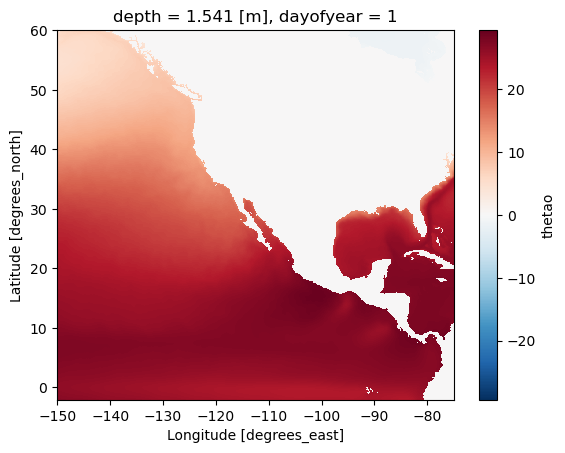

In [32]:
smooth_climatology.thetao.isel(depth = 1, dayofyear = 0).plot()

In [ ]:
smooth_climatology.zos.mean("dayofyear").plot()